In [13]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib

DATA_DIR = Path("../data")
RAW_DIR = DATA_DIR / "GSE85112_RAW"

bundle = joblib.load(DATA_DIR / "hema_small_panel_coarse_model.joblib")
clf = bundle["clf"]
scaler = bundle["scaler"]
gene_cols = bundle["gene_cols"]
classes = bundle["classes"]

classes, len(gene_cols)

(['Bcell', 'DC', 'Erythroid', 'HSC_like', 'Myeloid', 'T_NK'], 17)

In [14]:
list(RAW_DIR.iterdir())


[PosixPath('../data/GSE85112_RAW/GSM2257878_HSPC_from_CB_counts.txt'),
 PosixPath('../data/GSE85112_RAW/.DS_Store'),
 PosixPath('../data/GSE85112_RAW/GSM2257877_HSPC_from_hiPSC_counts.txt')]

In [16]:
hi_path = RAW_DIR / "GSM2257877_HSPC_from_hiPSC_counts.txt"   # adjust exact names
cb_path = RAW_DIR / "GSM2257878_HSPC_from_CB_counts.txt"

hi_test = pd.read_csv(hi_path, sep="\t", comment="#")
cb_test = pd.read_csv(cb_path, sep="\t", comment="#")

hi_test.head(), hi_test.columns

(                 gene  Sum_counts  Sum_ambig  \
 0  ENSG00000000003.14      2186.0      370.0   
 1   ENSG00000000005.5       294.0      132.0   
 2  ENSG00000000419.12       679.0      164.0   
 3  ENSG00000000457.13      1209.0      400.0   
 4  ENSG00000000460.16      1759.0      466.0   
 
                                               Ambigs  bc0001  bc0002  bc0003  \
 0  ENSG00000184840.11 ENSG00000196141.12 ENSG0000...     5.0     2.0     5.0   
 1  ENSG00000127540.11 ENSG00000146776.14 ENSG0000...     2.0     1.0     2.0   
 2  ENSG00000004866.18 ENSG00000130147.15 ENSG0000...     5.0     1.0     1.0   
 3  ENSG00000050555.17 ENSG00000140398.13 ENSG0000...    18.0     0.0     2.0   
 4  ENSG00000183873.15 ENSG00000166546.13 ENSG0000...    14.0    10.0     8.0   
 
    bc0004  bc0005  bc0006  ...  bc1036  bc1037  bc1038  bc1039  bc1040  \
 0     6.0     7.0     5.0  ...     0.0     0.0     0.0     0.0     0.0   
 1     3.0     0.0     1.0  ...     1.0     0.0     0.0     0.0   

In [17]:
gene_col = "gene"
count_col = "count"

In [19]:
gene_col = "gene"          # from hi_test.columns
count_col = "Sum_counts"   # use this as bulk count per gene

def load_counts_table(path, gene_col, count_col, sample_name):
    df = pd.read_csv(path, sep="\t", comment="#")
    sub = df[[gene_col, count_col]].copy()
    sub.columns = ["gene", sample_name]
    sub = sub.set_index("gene")
    return sub

hi_bulk = load_counts_table(hi_path, gene_col, count_col, "HSPC_hiPSC")
cb_bulk = load_counts_table(cb_path, gene_col, count_col, "HSPC_CB")

expr_raw = pd.concat([hi_bulk, cb_bulk], axis=1)  # genes x 2 samples
expr_raw = expr_raw[~expr_raw.index.duplicated(keep="first")]

expr_raw.head(), expr_raw.shape

(                    HSPC_hiPSC  HSPC_CB
 gene                                   
 ENSG00000000003.14      2186.0    658.0
 ENSG00000000005.5        294.0    200.0
 ENSG00000000419.12       679.0    418.0
 ENSG00000000457.13      1209.0    652.0
 ENSG00000000460.16      1759.0   1113.0,
 (34021, 2))

In [21]:
expr_log = np.log2(expr_raw + 1)

expr_t = expr_log.T
expr_t.head(), expr_t.shape


(gene        ENSG00000000003.14  ENSG00000000005.5  ENSG00000000419.12  \
 HSPC_hiPSC           11.094738           8.204571            9.409391   
 HSPC_CB               9.364135           7.651052            8.710806   
 
 gene        ENSG00000000457.13  ENSG00000000460.16  ENSG00000000938.12  \
 HSPC_hiPSC           10.240791           10.781360            9.902375   
 HSPC_CB               9.350939           10.121534            9.136991   
 
 gene        ENSG00000000971.15  ENSG00000001036.13  ENSG00000001084.10  \
 HSPC_hiPSC            9.361944           10.643856           10.280771   
 HSPC_CB               8.951285            9.616549            9.370687   
 
 gene        ENSG00000001167.14  ...  ENSG00000283104.1  ENSG00000283105.1  \
 HSPC_hiPSC            9.350939  ...           7.948367           5.523562   
 HSPC_CB               8.108524  ...           7.044394           4.392317   
 
 gene        ENSG00000283107.1  ENSG00000283110.1  ENSG00000283114.1  \
 HSPC_hiPSC   

In [22]:
for g in gene_cols:
    if g not in expr_t.columns:
        expr_t[g] = np.nan

expr_t = expr_t[gene_cols]

expr_t = expr_t.apply(lambda col: col.fillna(col.mean()), axis=0)

expr_t.head()


gene,TAL1,MEIS1,RUNX1,NPM1,FLT3,MPO,SPI1,ELANE,IDH1,KIT,GATA1,KLF1,DNMT3A,CSF3R,GATA2,IDH2,SOD1
HSPC_hiPSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSPC_CB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
X_gse = scaler.transform(expr_t.values)

proba = clf.predict_proba(X_gse)
pred = clf.predict(X_gse)

proba_df = pd.DataFrame(proba, index=expr_t.index, columns=classes)
results_gse = proba_df.copy()
results_gse["pred_coarse_type"] = pred

results_gse


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [24]:
ensembl_to_symbol = {
    "ENSG00000142168": "SOD1",
    "ENSG00000179348": "GATA2",
    "ENSG00000159216": "RUNX1",
    "ENSG00000162367": "TAL1",
    "ENSG00000143995": "MEIS1",
    "ENSG00000005381": "MPO",
    "ENSG00000197561": "ELANE",
    "ENSG00000105610": "KLF1",
    "ENSG00000102145": "GATA1",
    "ENSG00000119535": "CSF3R",
    "ENSG00000122025": "FLT3",
    "ENSG00000181163": "NPM1",
    "ENSG00000157404": "KIT",
    "ENSG00000119772": "DNMT3A",
    "ENSG00000138413": "IDH1",
    "ENSG00000182054": "IDH2",
    "ENSG00000185842": "SPI1",   # PU.1
}


In [25]:
expr_raw = expr_raw.reset_index().rename(columns={"index": "gene"})

expr_raw["ensembl_base"] = expr_raw["gene"].str.split(".").str[0]

expr_raw["symbol"] = expr_raw["ensembl_base"].map(ensembl_to_symbol)

expr_raw = expr_raw[expr_raw["symbol"].notna()]

expr_raw = (
    expr_raw
    .drop(columns=["gene", "ensembl_base"])
    .groupby("symbol", as_index=True)
    .sum()
)

expr_raw.head(), expr_raw.shape


(        HSPC_hiPSC  HSPC_CB
 symbol                     
 CSF3R        971.0   1140.0
 DNMT3A      2181.0   1410.0
 ELANE        122.0    259.0
 FLT3         474.0    510.0
 GATA1        308.0    399.0,
 (17, 2))

In [27]:
gene_cols = [
    "SOD1","GATA2","RUNX1","TAL1","MEIS1","SPI1","MPO","ELANE",
    "KLF1","GATA1","CSF3R","FLT3","NPM1","KIT","DNMT3A","IDH1","IDH2"
]

expr_panel = expr_raw.reindex(gene_cols)

import numpy as np
import pandas as pd

bloodspot_means = pd.Series(
    scaler.mean_, 
    index=gene_cols
)

def fill_missing_gene(row):
    gene = row.name
    if row.isna().all():
        return pd.Series(
            bloodspot_means.loc[gene],
            index=row.index
        )
    else:
        return row.fillna(row.mean()) 

expr_panel = expr_panel.apply(fill_missing_gene, axis=1)

expr_t = expr_panel.T
expr_t.head()
expr_t.isna().sum()


symbol
SOD1      0
GATA2     0
RUNX1     0
TAL1      0
MEIS1     0
SPI1      0
MPO       0
ELANE     0
KLF1      0
GATA1     0
CSF3R     0
FLT3      0
NPM1      0
KIT       0
DNMT3A    0
IDH1      0
IDH2      0
dtype: int64

In [28]:
X_gse = scaler.transform(expr_t.values)
proba = clf.predict_proba(X_gse)
pred  = clf.predict(X_gse)

proba_df = pd.DataFrame(proba, index=expr_t.index, columns=classes)

results_gse = proba_df.copy()
results_gse["pred_coarse_type"] = pred

results_gse


,Bcell,DC,Erythroid,HSC_like,Myeloid,T_NK,pred_coarse_type
HSPC_hiPSC,0.0,0.0,0.0,1.0,0.0,0.0,HSC_like
HSPC_CB,0.0,0.0,0.0,1.0,0.0,0.0,HSC_like


In [29]:
results_gse["HSC_identity"] = results_gse["HSC_like"]
results_gse


,Bcell,DC,Erythroid,HSC_like,Myeloid,T_NK,pred_coarse_type,HSC_identity
HSPC_hiPSC,0.0,0.0,0.0,1.0,0.0,0.0,HSC_like,1.0
HSPC_CB,0.0,0.0,0.0,1.0,0.0,0.0,HSC_like,1.0


In [30]:
bs = pd.read_csv(DATA_DIR / "bloodspot_small_panel.tsv", sep="\t")

mapping = {}
HSC_like = ['HSC CD38- CD34+', 'HSC CD133+ CD34dim']
Erythroid = ['Eryth', 'MEP', 'CFU-Megakaryo', 'Megakaryocyte']
Myeloid = ['CFU-Granulo', 'CFU-Mono', 'CMP', 'Granulo (Neutro)', 'Gran',
           'Monocyte', 'Basophils', 'Eosinophill', 'Myeloid DC']
Bcell = ['B-cell class can switch', 'B-cell class switched', 'B-cells',
         'Naive B-cells', 'Early B-cell', 'Pro B-cell']
T_NK = ['CD4+Centr', 'CD4+Effec', 'CD8+Centr', 'CD8+Effec',
        'Naive CD4+ T-cell', 'Naive CD8+ T-cell',
        'NK CD56+CD16+', 'NK CD56-CD16+', 'NK CD56-CD16-', 'NKT']
DC = ['Plasmacytoid DC']

for ct in HSC_like: mapping[ct] = "HSC_like"
for ct in Erythroid: mapping[ct] = "Erythroid"
for ct in Myeloid: mapping[ct] = "Myeloid"
for ct in Bcell: mapping[ct] = "Bcell"
for ct in T_NK: mapping[ct] = "T_NK"
for ct in DC: mapping[ct] = "DC"

bs["coarse_type"] = bs["cell_type"].map(mapping)

X_bs = bs[gene_cols].values
X_bs_scaled = scaler.transform(X_bs)

hsc_ref = X_bs_scaled[bs["coarse_type"] == "HSC_like"].mean(axis=0)

def cosine_similarity_to_ref(X, ref):
    X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)
    ref_norm = ref / (np.linalg.norm(ref) + 1e-8)
    return X_norm @ ref_norm

results_gse["HSC_fidelity"] = cosine_similarity_to_ref(X_gse, hsc_ref)
results_gse

,Bcell,DC,Erythroid,HSC_like,Myeloid,T_NK,pred_coarse_type,HSC_identity,HSC_fidelity
HSPC_hiPSC,0.0,0.0,0.0,1.0,0.0,0.0,HSC_like,1.0,0.893561
HSPC_CB,0.0,0.0,0.0,1.0,0.0,0.0,HSC_like,1.0,0.899087


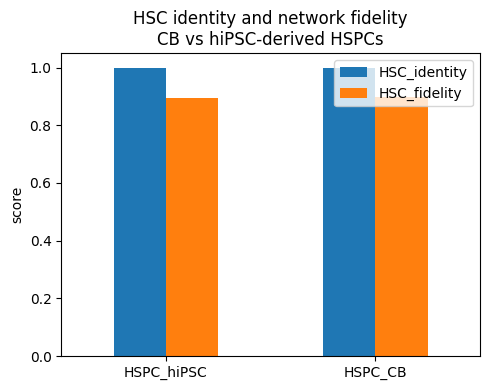

In [31]:
import matplotlib.pyplot as plt

results_gse[["HSC_identity", "HSC_fidelity"]].plot(
    kind="bar", rot=0, figsize=(5,4)
)
plt.ylabel("score")
plt.title("HSC identity and network fidelity\nCB vs hiPSC-derived HSPCs")
plt.tight_layout()
plt.show()

In [32]:
results_gse[["HSC_identity", "HSC_fidelity", "pred_coarse_type"]]

,HSC_identity,HSC_fidelity,pred_coarse_type
HSPC_hiPSC,1.0,0.893561,HSC_like
HSPC_CB,1.0,0.899087,HSC_like


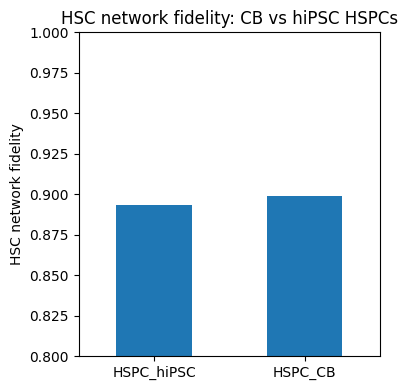

In [33]:
ax = results_gse[["HSC_fidelity"]].plot(
    kind="bar", rot=0, figsize=(4,4), legend=False
)
ax.set_ylim(0.8, 1.0)  # zoom around the interesting range
ax.set_ylabel("HSC network fidelity")
ax.set_title("HSC network fidelity: CB vs hiPSC HSPCs")
plt.tight_layout()
plt.show()

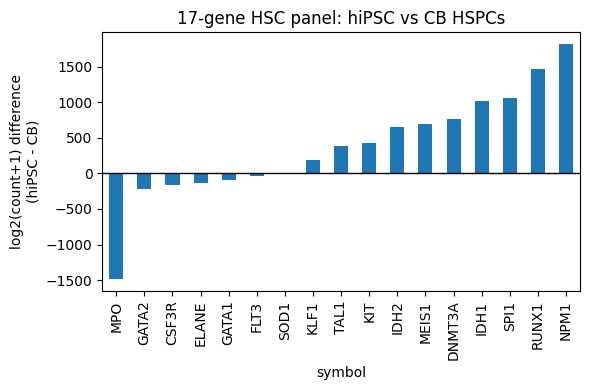

In [35]:
diff = (expr_t.loc["HSPC_hiPSC"] - expr_t.loc["HSPC_CB"]).sort_values()

plt.figure(figsize=(6,4))
diff.plot(kind="bar")
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("log2(count+1) difference\n(hiPSC - CB)")
plt.title("17-gene HSC panel: hiPSC vs CB HSPCs")
plt.tight_layout()
plt.show()


/Users/travishong/miniforge3/envs/hema-cellnet-lite/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


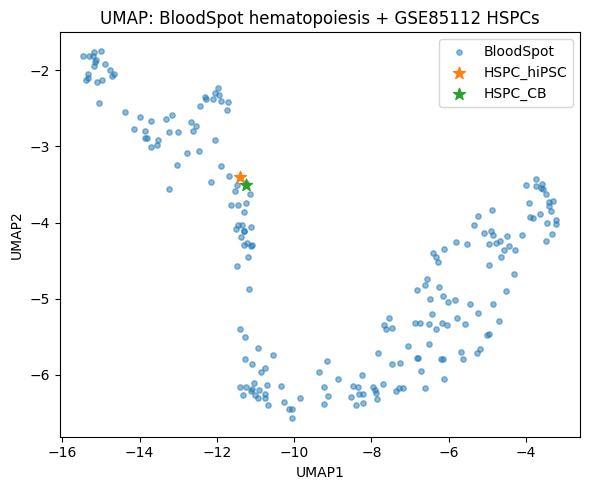

In [37]:
from umap import UMAP

bs = pd.read_csv(DATA_DIR / "bloodspot_small_panel.tsv", sep="\t")

mapping = {}
HSC_like = ['HSC CD38- CD34+', 'HSC CD133+ CD34dim']
Erythroid = ['Eryth', 'MEP', 'CFU-Megakaryo', 'Megakaryocyte']
Myeloid = [
    'CFU-Granulo', 'CFU-Mono', 'CMP', 'Granulo (Neutro)', 'Gran',
    'Monocyte', 'Basophils', 'Eosinophill', 'Myeloid DC'
]
Bcell = [
    'B-cell class can switch', 'B-cell class switched', 'B-cells',
    'Naive B-cells', 'Early B-cell', 'Pro B-cell'
]
T_NK = [
    'CD4+Centr', 'CD4+Effec', 'CD8+Centr', 'CD8+Effec',
    'Naive CD4+ T-cell', 'Naive CD8+ T-cell',
    'NK CD56+CD16+', 'NK CD56-CD16+', 'NK CD56-CD16-', 'NKT'
]
DC = ['Plasmacytoid DC']

for ct in HSC_like: mapping[ct] = "HSC_like"
for ct in Erythroid: mapping[ct] = "Erythroid"
for ct in Myeloid: mapping[ct] = "Myeloid"
for ct in Bcell: mapping[ct] = "Bcell"
for ct in T_NK: mapping[ct] = "T_NK"
for ct in DC: mapping[ct] = "DC"

bs["coarse_type"] = bs["cell_type"].map(mapping)

bs["coarse_type"].value_counts()

X_bs = bs[gene_cols].values
X_bs_scaled = scaler.transform(X_bs)

X_all = np.vstack([X_bs_scaled, X_gse])
labels_all = list(bs["coarse_type"].values) + list(results_gse.index)

umap_all = UMAP(random_state=42)
emb_all = umap_all.fit_transform(X_all)

umap_df = pd.DataFrame(emb_all, columns=["UMAP1", "UMAP2"])
umap_df["label"] = labels_all

umap_df["is_gse"] = umap_df["label"].isin(results_gse.index)

plt.figure(figsize=(6,5))
mask_gse = umap_df["is_gse"]
plt.scatter(
    umap_df.loc[~mask_gse, "UMAP1"],
    umap_df.loc[~mask_gse, "UMAP2"],
    s=15, alpha=0.5, label="BloodSpot"
)

for name in results_gse.index:
    row = umap_df[umap_df["label"] == name].iloc[0]
    plt.scatter(row["UMAP1"], row["UMAP2"], s=80, marker="*", label=name)

plt.legend()
plt.title("UMAP: BloodSpot hematopoiesis + GSE85112 HSPCs")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()
